Setup and Data Loading

In [ ]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Machine learning and preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve

# Imbalanced-learn and pipeline
from imblearn.over_sampling import SVMSMOTE, BorderlineSMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline as SKLearnPipeline

# Load the dataset
try:
    df = pd.read_csv('generated_dataset.csv')
except FileNotFoundError:
    print("Error: The file 'generated_dataset.csv' was not found.")


# Define the target variable 'leak_status' based on a threshold
threshold = 0.25
df['leak_status'] = np.where(df['CR-corrosion defect'] >= threshold, 'Leak', 'No Leak')

# Display the first few rows to confirm changes
display(df.head())

,Wellhead Temp. (C),Wellhead Press (psi),MMCFD- gas,BOPD (barrel of oil produced per day),BWPD (barrel of water produced per day),BSW - basic solid and water (%),CO2 mol. (%) @ 25 C & 1 Atm.,Gas Grav.,CR-corrosion defect,leak_status
0,53.35,1105.13,12.87,1378.93,2812.62,75.64,3.3628,0.7205,0.2245,No Leak
1,72.25,1026.31,3.42,1028.75,919.92,44.21,3.8679,0.8940,0.2262,No Leak
2,65.08,722.96,6.23,2017.92,1212.42,17.55,2.3552,0.7661,0.2305,No Leak
3,60.71,1557.23,11.71,558.22,1716.09,65.79,1.7253,0.7738,0.2303,No Leak
4,46.19,1304.42,8.58,1280.47,1929.22,37.45,1.8327,0.7611,0.2202,No Leak


 Exploratory Data Analysis

Missing values in each column:
 Wellhead Temp. (C)                         0
Wellhead Press (psi)                       0
MMCFD- gas                                 0
BOPD (barrel of oil produced per day)      0
BWPD (barrel of water produced per day)    0
BSW - basic solid and water (%)            0
CO2 mol. (%) @ 25 C & 1 Atm.               0
Gas Grav.                                  0
CR-corrosion defect                        0
leak_status                                0
dtype: int64

Summary statistics:
        Wellhead Temp. (C)  Wellhead Press (psi)    MMCFD- gas  \
count        10292.000000          10292.000000  10292.000000   
mean            57.352401           1361.783583      8.851533   
std              9.423529            559.275420      4.968737   
min             41.070000            382.080000      0.230000   
25%             49.220000            880.000000      4.570000   
50%             57.360000           1364.900000      8.880000   
75%             65.412500   

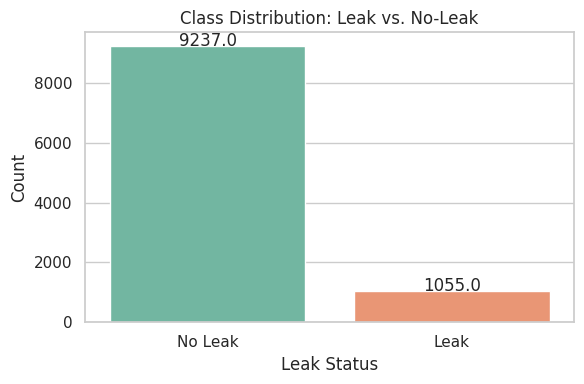

In [39]:
# Check for missing values
print("Missing values in each column:\n", df.isnull().sum())

# Summary statistics of numerical columns
print("\nSummary statistics:\n", df.describe())

# Class distribution
class_distribution = df['leak_status'].value_counts(normalize=True) * 100
print("\nClass distribution (in %):\n", class_distribution)

# Visualizing the class distribution
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='leak_status', hue='leak_status', palette='Set2', legend=False)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{height}', ha="center")
plt.title('Class Distribution: Leak vs. No-Leak')
plt.xlabel('Leak Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Data Preprocessing and Splitting

In [40]:
# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(df['leak_status'])

# Drop the original numerical target and the threshold-based column
X = df.drop(['CR-corrosion defect', 'leak_status'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (6175, 8), y_train shape: (6175,)
X_test shape: (4117, 8), y_test shape: (4117,)


 Baseline Model Performance

In [ ]:
print("--- Evaluating Baseline Model (WITHOUT SMOTE) ---")

# Cross-validation strategy
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline without a resampling step (smote)
no_smote_pipeline = SKLearnPipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=1.0, kernel='rbf', gamma='scale', class_weight=None, random_state=42))
])

# Calculate cross-validation scores using f1 as the metric
no_smote_scores = cross_val_score(
    estimator=no_smote_pipeline,
    X=X_train,
    y=y_train,
    cv=cv_folds,
    scoring='f1',
    n_jobs=-1
)

# Print the results
print(f"\nBaseline F1 Scores for each fold: {np.round(no_smote_scores, 4)}")
print(f"Mean Baseline F1 Score: {np.mean(no_smote_scores):.4f} +/- {np.std(no_smote_scores):.4f}")

--- Evaluating Baseline Model (WITHOUT SMOTE) ---

Baseline F1 Scores for each fold: [0.9749 0.9767 0.9757 0.9796 0.9779]
Mean Baseline F1 Score: 0.9769 +/- 0.0017



--- Evaluating Baseline Model on Test Set ---


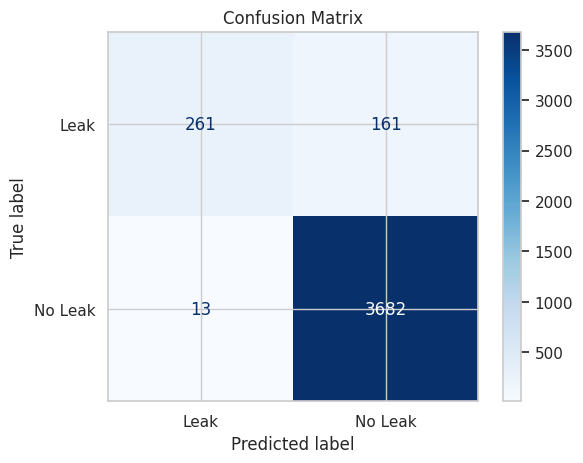

,precision,recall,f1-score,support
Leak,0.95,0.62,0.75,422.00
No Leak,0.96,1.00,0.98,3695.00
accuracy,0.96,0.96,0.96,0.96
macro avg,0.96,0.81,0.86,4117.00
weighted avg,0.96,0.96,0.95,4117.00


In [47]:
print("\n--- Evaluating Baseline Model on Test Set ---")

# Fit the pipeline on the training data
no_smote_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = no_smote_pipeline.predict(X_test)

# Evaluate the model
ConfusionMatrixDisplay.from_estimator(no_smote_pipeline, X_test, y_test, display_labels=le.classes_, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report = df_report.round(2)
display(df_report)

Evaluating the Impact of SMOTE (Before Tuning)


--- Evaluating Model (WITH SMOTE) before tuning ---
F1 Scores with SMOTE for each fold: [0.9665 0.9736 0.9669 0.9688 0.9682]
Mean F1 Score with SMOTE: 0.9688 +/- 0.0025


/tmp/ipykernel_1719/32871358.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


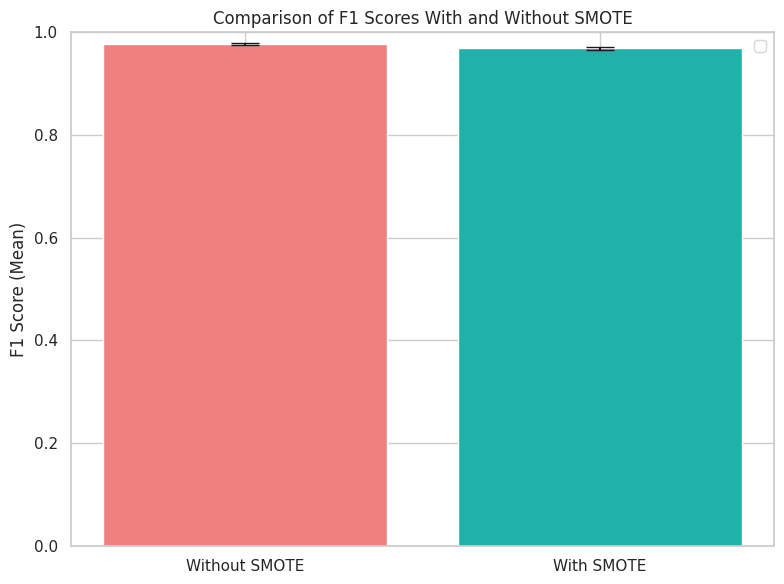


Conclusion: The use of SMOTE did not significantly improve the model's performance on the training data.


In [48]:
print("\n--- Evaluating Model (WITH SMOTE) before tuning ---")

# Define the pipeline with the SMOTE step
smote_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svmsmote', SVMSMOTE(random_state=42)),
    ('svc', SVC(C=1.0, kernel='rbf', gamma='scale', class_weight='balanced', random_state=42))
])

# Calculate cross-validation scores
smote_scores = cross_val_score(
    estimator=smote_pipeline,
    X=X_train,
    y=y_train,
    cv=cv_folds,
    scoring='f1',
    n_jobs=-1
)

# Print and visualize the comparison
print(f"F1 Scores with SMOTE for each fold: {np.round(smote_scores, 4)}")
print(f"Mean F1 Score with SMOTE: {np.mean(smote_scores):.4f} +/- {np.std(smote_scores):.4f}")

# Plotting the comparison
labels = ['Without SMOTE', 'With SMOTE']
mean_scores = [np.mean(no_smote_scores), np.mean(smote_scores)]
std_devs = [np.std(no_smote_scores), np.std(smote_scores)]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, mean_scores, yerr=std_devs, capsize=10, color=['lightcoral', 'lightseagreen'])
plt.title('Comparison of F1 Scores With and Without SMOTE')
plt.ylabel('F1 Score (Mean)')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

if np.mean(smote_scores) > np.mean(no_smote_scores):
    print("\nConclusion: The use of SMOTE significantly improved the model's performance on the training data.")
else:
    print("\nConclusion: The use of SMOTE did not significantly improve the model's performance on the training data.")


--- Evaluating Model (with smote) on Test Set ---


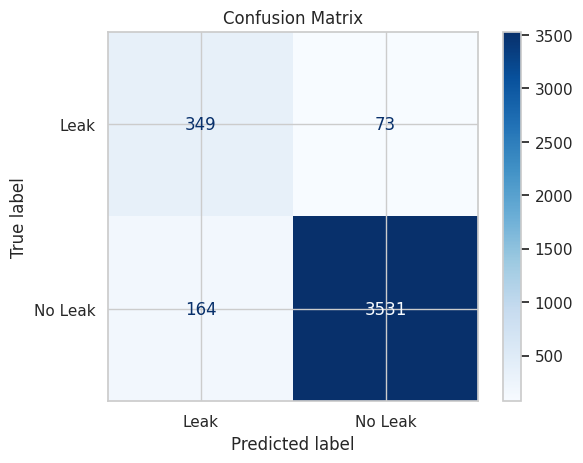

,precision,recall,f1-score,support
Leak,0.68,0.83,0.75,422.00
No Leak,0.98,0.96,0.97,3695.00
accuracy,0.94,0.94,0.94,0.94
macro avg,0.83,0.89,0.86,4117.00
weighted avg,0.95,0.94,0.94,4117.00


In [45]:
print("\n--- Evaluating Model (with smote) on Test Set ---")

# Fit the pipeline on the training data
smote_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = smote_pipeline.predict(X_test)

# Evaluate the model
ConfusionMatrixDisplay.from_estimator(smote_pipeline, X_test, y_test, display_labels=le.classes_, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report = df_report.round(2)
display(df_report)

Hyperparameter Tuning with GridSearchCV

In [50]:
print("--- Starting Hyperparameter Tuning with GridSearchCV ---")

# Define the parameter grid for the search
param_grid = {
    'svmsmote__k_neighbors': [3, 5, 7], 
    'svc__C': np.logspace(-2, 1, 5),     
    'svc__gamma': ['scale', 0.1, 1],
    'svc__kernel': ['linear', 'rbf']     
}

# Create the GridSearchCV object, using the SMOTE pipeline from before
grid_search = GridSearchCV(
    estimator=smote_pipeline,
    param_grid=param_grid,
    cv=cv_folds,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV to the training data. This will perform resampling
# inside each cross-validation fold to prevent data leakage.
grid_search.fit(X_train, y_train)

# Print the best parameters and best score from the search
print("\nGrid Search Best Parameters:", grid_search.best_params_)
print(f"Grid Search Best F1 Score: {grid_search.best_score_:.4f}")

--- Starting Hyperparameter Tuning with GridSearchCV ---
Fitting 5 folds for each of 90 candidates, totalling 450 fits


KeyboardInterrupt: 

 Final Model Evaluation on Test Data

In [ ]:
# Retrieve the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the unseen test set
y_pred = best_model.predict(X_test)
y_scores = best_model.decision_function(X_test)

print("\n--- Final Evaluation on Test Set using Tuned Model ---")

# Print the classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=le.classes_, cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Data")
plt.show()

# Plot the ROC curve
test_roc_auc = roc_auc_score(y_test, y_scores)
fpr, tpr, _ = roc_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Plotting the F1 Curve

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

# Make predictions on the test set. SVC with probability=True gives probabilities
# for each class. We need the probabilities for the positive class (class 1).
y_probs = best_model.predict_proba(X_test)[:, 1]

# Calculate precision and recall for all possible thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Calculate the F1 score for each threshold
f1_scores = (2 * precision * recall) / (precision + recall)
f1_scores[np.isnan(f1_scores)] = 0

# Find the threshold that corresponds to the maximum F1 score
optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
optimal_f1 = f1_scores[optimal_threshold_idx]

# Plot the F1 curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score Curve', color='purple', lw=2)

# Highlight the optimal threshold
plt.axvline(x=optimal_threshold, color='red', linestyle='--',
            label=f'Optimal Threshold = {optimal_threshold:.3f}\n(Max F1 Score = {optimal_f1:.3f})')
plt.plot(optimal_threshold, optimal_f1, 'ro', markersize=10)

plt.xlabel('Classification Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Classification Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"The optimal classification threshold is approximately {optimal_threshold:.3f}, which yields an F1 score of {optimal_f1:.3f}.")

Plotting the Learning Curve

In [ ]:
from sklearn.model_selection import learning_curve
from imblearn.pipeline import Pipeline as ImbPipeline # Use a different alias for clarity

# Ensure the best_model has probability=True for consistent evaluation if needed.
# If grid_search already set it, this step is for safety.
if 'svc__probability' not in grid_search.best_params_:
    best_model.set_params(svc__probability=True)

print("--- Generating Learning Curve ---")

# Use a StratifiedKFold cross-validator for stable splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Generate learning curve data
# The learning_curve function will automatically run the pipeline
# on various subsets of the training data.
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring='f1', # Use the same scoring metric as your grid search
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), # Use 10 points between 10% and 100% of data
)

# Calculate the mean and standard deviation for the scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 7))
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.grid()

# Plot the training score with a confidence band
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')

# Plot the validation score with a confidence band
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Cross-Validation Score')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='g')

plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Interpretation
print("\n--- Interpreting the Learning Curve ---")
print("1. If the training score is high and the cross-validation score is low, the model may have high variance (overfitting).")
print("2. If both scores are low and close to each other, the model may have high bias (underfitting).")
print("3. If both scores are high and converge as the training set size increases, the model is performing well.")